In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# keras functionality
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import (Activation, Add, Average, AvgPool1D, AvgPool2D, BatchNormalization, Concatenate, Conv1D, Conv2D,
                                     Dense, Dropout, Flatten, Input, Lambda, LayerNormalization, MaxPool1D, MaxPool2D, Reshape)

# Read in data

In [2]:
od_feats = np.load('../data/offense_vs_defensive_features.npy')

In [3]:
od_feats.shape

(31007, 10, 11, 14)

In [4]:
n_feats = od_feats.shape[3]

In [5]:
Yards = pd.read_csv('../data/yard_outcomes.csv')

In [6]:
Yards.head()

,GameId,PlayId,Yards,YardsToTouchdown,YardsToSafety,YardIndex,YardIndexClipped,UnclippedYardIndex
0,2017090700,20170907000118,8,65,35,13,13,107
1,2017090700,20170907000139,3,57,43,8,8,102
2,2017090700,20170907000189,5,35,65,10,10,104
3,2017090700,20170907000345,2,2,98,7,7,101
4,2017090700,20170907000395,7,75,25,12,12,106


In [7]:
negative_yards_cap = abs(Yards[Yards['YardIndexClipped'] == 0].Yards.max())
negative_yards_cap

5

In [8]:
num_classes = Yards.YardIndexClipped.max() - Yards.YardIndexClipped.min() + 1
num_classes

36

In [9]:
N = Yards.shape[0]
Y = np.zeros((N, num_classes))
for i in range(N):
    index_location = Yards.loc[i, 'YardIndexClipped']
    Y[i, index_location] = 1

In [10]:
Y_unclipped = np.zeros((N, 199))
for i in range(N):
    index_location = Yards.loc[i, 'UnclippedYardIndex']
    Y_unclipped[i, index_location] = 1

# Standardize Features

In [11]:
# X = (od_feats - od_feats.mean(axis=0))/(od_feats.std(axis=0))
X = od_feats

# Split data into train/val/test

In [12]:
N = Yards.shape[0]
train_perc = 0.80
val_test_perc = 0.50

train_N = int(N*train_perc)
val_N = int((N-train_N)*val_test_perc)
test_N = int(N-train_N-val_N)
(train_N, val_N, test_N)

(24805, 3101, 3101)

In [13]:
train_indx = np.random.choice(a=Yards.index, size=train_N, replace=False)

remaining_indexes = [x for x in Yards.index if x not in train_indx]
val_indx = np.random.choice(a=remaining_indexes, size=val_N, replace=False)

test_indx = [x for x in remaining_indexes if x not in val_indx]

print(len(train_indx), len(val_indx), len(test_indx))

24805 3101 3101


In [14]:
X_train = X[train_indx, :, :]
X_val = X[val_indx, :, :]
X_test = X[test_indx, :, :]

train_range = Yards.loc[train_indx, ['YardsToTouchdown','YardsToSafety']]
val_range = Yards.loc[val_indx, ['YardsToTouchdown','YardsToSafety']]
test_range = Yards.loc[test_indx, ['YardsToTouchdown','YardsToSafety']]

y_train = Y[train_indx, :]
y_val = Y[val_indx, :]
y_test = Y[test_indx, :]

y_train_unclipped = Y_unclipped[train_indx, :]
y_val_unclipped = Y_unclipped[val_indx, :]
y_test_unclipped = Y_unclipped[test_indx, :]

print((X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape))

((24805, 10, 11, 14), (24805, 36)) ((3101, 10, 11, 14), (3101, 36)) ((3101, 10, 11, 14), (3101, 36))


# Define Model Architecture

In [15]:
K.clear_session()

# input dimension is 10 offensive players x 11 defensive players x n_feats
inputs = Input(shape=(10,11,n_feats))

x = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(inputs)
x = Conv2D(160, kernel_size=(1,1), strides=(1,1), activation='relu')(x)
x = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation='relu')(x)

# pooling is done such that we have aggregated offensive information
# over each of the 11 defensive players. This way we have information
# about defensive players and how they relate to the RB in our last
# block of Convs
a = AvgPool2D(pool_size=(10,1))(x)
a = Lambda(lambda x: x*0.7)(a)
m = MaxPool2D(pool_size=(10,1))(x)
m = Lambda(lambda x: x*0.3)(m)

x = Add()([a, m])
x = Reshape((11,128))(x)

x = BatchNormalization()(x)

x = Conv1D(160, kernel_size=1, strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(96, kernel_size=1, strides=1, activation='relu')(x)
x = BatchNormalization()(x)
x = Conv1D(96, kernel_size=1, strides=1, activation='relu')(x)
x = BatchNormalization()(x)

a = AvgPool1D(pool_size=11)(x)
a = Lambda(lambda x: x*0.7)(a)
m = MaxPool1D(pool_size=11)(x)
m = Lambda(lambda x: x*0.3)(m)

x = Add()([a,m])
x = Flatten()(x)

x = Dense(96, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs = inputs, outputs = output)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 11, 14)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 11, 128)  1920        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 10, 11, 160)  20640       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 10, 11, 128)  20608       conv2d_1[0][0]                   
______________________________________________________________________________________________

#### Define Callbacks and Early Stopping

In [17]:
def crps(y_true, y_pred):
    N = len(y_true)
    
    num = K.sum(K.sum((K.cumsum(y_pred, axis = 1) - K.cumsum(y_true, axis=1))**2, axis=1), axis=0)
    den = float(199*N)
    loss = num/den
    return loss

def postprocessing(preds, yards_to_safety, yards_to_touchdown, negative_cap, positive_cap):
    # cases where the number of yards
    # for a touchdown run are less
    # than the number of yard classes
    # we are predicting. An example
    # would be the ball at the opponent 2 yard line
    # while the max number of yards we are
    # predicting is 30. In this case we should
    # cap our prediction at 2 yards.
    if yards_to_touchdown < positive_cap:
        starting_cap_index = positive_cap - yards_to_touchdown - 1
        total_predictions_after_cap = np.sum(preds[starting_cap_index:])
        preds[starting_cap_index] = preds[starting_cap_index] + total_predictions_after_cap
    
    # we also need to consider the ball deep in our own territory.
    # now we need to evaluate whether or not the yards to a safety
    # is less than the number of negative yard classes being predicted.
    # So if we are at our own 2 and we are predicting a max loss of 5
    # yards, then we know we can cap our loss at 2 yards instead of 5.
    if yards_to_safety < negative_cap:
        ending_cap_index = negative_cap - yards_to_safety
        total_predictions_prior_cap = np.sum(preds[:ending_cap_index])
        preds[ending_cap_index] = preds[ending_cap_index] + total_predictions_prior_cap
        preds[:ending_cap_index] = 0
        
    preds = np.clip(np.cumsum(preds), 0, 1)
    
    return preds

def full_yards_distribution_crps(y_preds, y_true, safety_td_distances):
    safety_yards = safety_td_distances.iloc[:, 0].values
    td_yards = safety_td_distances.iloc[:, 1].values
    N = y_preds.shape[0]
    
    # clean up predictions based on possible loss/gain
    capped_preds = np.zeros((N, num_classes))
    for indx,val in enumerate(y_preds):
        capped_pred = postprocessing(val, safety_yards[indx], td_yards[indx], negative_yards_cap, num_classes)
        capped_preds[indx] = capped_pred
    
    # now we need to append 0% and 100% to the front and back of range subset to get our full -99 to +99 prediction range
    full_preds = np.zeros((N, 199))
    start_indx = 99 - negative_yards_cap
    end_indx = 99 + num_classes - negative_yards_cap
    
    full_preds[:, start_indx:end_indx] = capped_preds
    full_preds[:, :start_indx] = 0
    full_preds[:, end_indx:] = 1
    
    y_true = np.cumsum(y_true, axis=1)
    loss = np.sum(np.sum((full_preds - y_true)**2, axis=1))/(199*N)
    
    return loss

In [18]:
class Metric(Callback):
    def __init__(self, model, callbacks, data):
        super().__init__()
        self.model = model
        self.callbacks = callbacks
        self.data = data

    def on_train_begin(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_end(logs)

    def on_epoch_end(self, batch, logs=None):
        # we have a train and val tuple
        # both house our features, clipped_yards, unclipped_yards, safety/td ranges
        train_tuple = self.data[0]
        val_tuple = self.data[1]
        
        X_train, y_train, y_train_unclipped, train_ranges = train_tuple[0], train_tuple[1], train_tuple[2], train_tuple[3]
        X_val, y_val, y_val_unclipped, val_ranges = val_tuple[0], val_tuple[1], val_tuple[2], val_tuple[3]
        
        # generate predictions
        train_preds = self.model.predict(X_train)
        val_preds = self.model.predict(X_val)
        
        # post-process of predictions based on possible loss/gain with safety/TD
        train_crps = full_yards_distribution_crps(train_preds, y_train_unclipped, train_ranges)
        val_crps = full_yards_distribution_crps(val_preds, y_val_unclipped, val_ranges)
        
        # store epoch train/val crps results in log
        # will access this information in model.history.history
        logs['train_CRPS'] = train_crps
        logs['val_CRPS'] = val_crps
        
        for callback in self.callbacks:
            callback.on_epoch_end(batch, logs)

In [19]:
es = EarlyStopping(monitor='val_CRPS', 
                   mode='min', 
                   restore_best_weights=True, 
                   verbose=1, 
                   patience=10)

es.set_model(model)

metric = Metric(model, [es], [(X_train, y_train, y_train_unclipped, train_range), 
                              (X_val, y_val, y_val_unclipped, val_range)])

opt = Adam(learning_rate=0.001)

In [20]:
model.compile(optimizer=opt, loss=crps)

In [21]:
n_epochs = 30
batch_size = 64

In [22]:
%%time
model.fit(X_train,
          y_train, 
          epochs=n_epochs,
          batch_size=batch_size,
          verbose=1,
          callbacks=[metric],
          validation_data=(X_val, y_val))

Epoch 1/30
388/388 [==============================] - 12s 27ms/step - loss: 0.0147 - val_loss: 0.0126oss: 0.0
Epoch 2/30
388/388 [==============================] - 11s 28ms/step - loss: 0.0134 - val_loss: 0.0125
Epoch 3/30
388/388 [==============================] - 9s 24ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 4/30
388/388 [==============================] - 10s 27ms/step - loss: 0.0130 - val_loss: 0.0124
Epoch 5/30
388/388 [==============================] - 11s 28ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 6/30
388/388 [==============================] - 11s 28ms/step - loss: 0.0128 - val_loss: 0.0125
Epoch 7/30
388/388 [==============================] - 11s 28ms/step - loss: 0.0128 - val_loss: 0.0121
Epoch 8/30
388/388 [==============================] - 11s 28ms/step - loss: 0.0127 - val_loss: 0.0124
Epoch 9/30
388/388 [==============================] - 12s 31ms/step - loss: 0.0127 - val_loss: 0.0121
Epoch 10/30
388/388 [==============================] - 10s 26ms/step - loss

In [23]:
history = model.history.history

train_history = history['train_CRPS']
val_history = history['val_CRPS']

indexes = [x for x in range(len(val_history))]

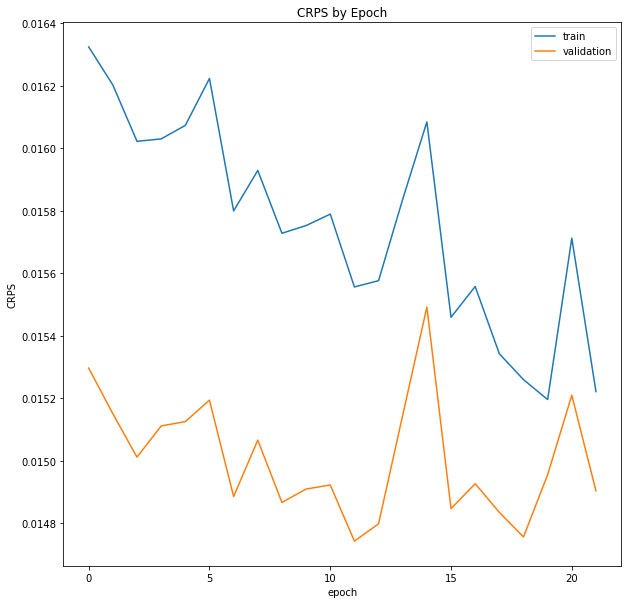

In [24]:
plt.figure(figsize=(10,10))
plt.plot(indexes, train_history)
plt.plot(indexes, val_history)
plt.xlabel('epoch')
plt.ylabel('CRPS')
plt.title('CRPS by Epoch')
plt.legend(['train','validation'])
plt.show()